In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

In [2]:
#get data

from data_utils import load_mnist

trX, teX, trY, teY = load_mnist(onehot=False)

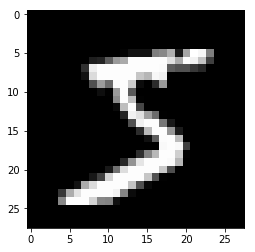

In [3]:
#view data

import matplotlib.pyplot as plt

plt.imshow(trX[0].reshape(28,28), cmap=plt.get_cmap('gray')) #need cmap thing or else is weird colour

In [4]:
#convert from numpy arrays to torch tensors

trX = torch.from_numpy(trX).float()
teX = torch.from_numpy(teX).float()
trY = torch.from_numpy(trY).long()
teY = torch.from_numpy(teY).long()

In [153]:
#create model

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(10)
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(20)
        
        self.fc = nn.Linear(7*7*20, output_size)
        
        self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) 
        x = x.view(x.size(0), -1) #from [32, 20, 7, 7] to [32, 980], 32 = batch size, 20 = no. of kernels, 7x7 = reshaped image
        x = self.fc(x)
        x = self.logsoftmax(x)
        return x

'   \nclass CNN(nn.Module):\n    def __init__(self):\n        super(CNN, self).__init__()\n        self.layer1 = nn.Sequential(\n            nn.Conv2d(1, 16, kernel_size=5, padding=2),\n            nn.BatchNorm2d(16),\n            nn.ReLU(),\n            nn.MaxPool2d(2))\n        self.layer2 = nn.Sequential(\n            nn.Conv2d(16, 32, kernel_size=5, padding=2),\n            nn.BatchNorm2d(32),\n            nn.ReLU(),\n            nn.MaxPool2d(2))\n        self.fc = nn.Linear(7*7*32, 10)\n        \n    def forward(self, x):\n        out = self.layer1(x)\n        out = self.layer2(out)\n        out = out.view(out.size(0), -1)\n        out = self.fc(out)\n        return out'

In [154]:
#create instance of Net class

net = Net(784, 100, 10)

In [155]:
#define some parameters

epochs = 10
batch_size = 32
learning_rate = 0.001
momentum = 0.9

In [156]:
#for plotting

plot_loss = []
plot_correct = []

In [157]:
#define loss and optimizer

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [158]:
#training function

def train(model, criterion, optimizer, x, y):
    x = Variable(x, requires_grad=False)
    y = Variable(y, requires_grad=False)
    
    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    loss = criterion(fx, y)

    # Backward
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.data[0]

In [159]:
#make predictions

def predict(model, x, y):
    x = Variable(x, requires_grad=False)
    outputs = model(x)
    _, predicted = torch.max(outputs.data, 1) #for each output, get the predicted value (torch.max returns (index, value) tuple)
    correct = (predicted == y) #how many predicted values equal the labels
    return correct.sum() 

In [ ]:
#run the training

num_examples = trX.shape[0]

#need to reshape to 4D to feed into convolutional neural net
trX = trX.view(-1, 1, 28, 28) #from [60000,784] to [60000, 1, 28, 28]
teX = teX.view(-1, 1, 28, 28)

for e in range(1, epochs+1):
    loss = 0.
    num_batches = num_examples // batch_size
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        loss += train(net, criterion, optimizer, trX[start:end], trY[start:end])
    correct = predict(net, teX, teY)
    plot_loss.append(loss/num_batches)
    plot_correct.append(correct/teX.shape[0]*100)
    print("Epoch %02d, loss = %f, accuracy = %.2f%%" % (e, loss / num_batches, correct/teX.shape[0]*100))

Epoch 01, loss = 0.255635, accuracy = 97.12%
Epoch 02, loss = 0.091116, accuracy = 98.01%
Epoch 03, loss = 0.069351, accuracy = 98.28%
Epoch 04, loss = 0.058234, accuracy = 98.40%
Epoch 05, loss = 0.050792, accuracy = 98.44%
Epoch 06, loss = 0.045406, accuracy = 98.49%
Epoch 07, loss = 0.041389, accuracy = 98.57%
Epoch 08, loss = 0.038098, accuracy = 98.62%
Epoch 09, loss = 0.035268, accuracy = 98.65%


0


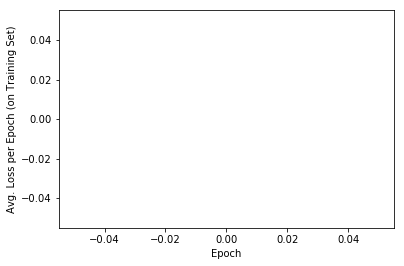

In [112]:
plt.plot(plot_loss)
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss per Epoch (on Training Set)')
print(len(plot_loss))

10


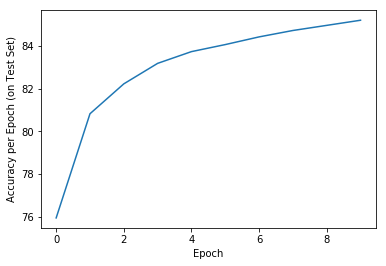

In [17]:
plt.plot(plot_correct)
plt.xlabel('Epoch')
plt.ylabel('Accuracy per Epoch (on Test Set)')
print(len(plot_correct))